<a href="https://colab.research.google.com/github/saidnaqwe/Web-Analytics-Data620/blob/main/Project_1_Said_Naqwe_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data 620 Web Analytics

Project 1

Said Naqwe

**Project Overview**

For this first project, here’s what we’re tackling:  
1. Find a network dataset that’s got some categorical info tied to each node.  
2. Figure out the degree centrality and eigenvector centrality for all the
nodes.  
3. Then, compare those centrality numbers across the categorical groups we pick.
Like, if I were using that dataset about high school romances in Columbus, Ohio (check it out here: http://researchnews.osu.edu/archive/chains.htm), I might see if the centrality stuff changes between guys and girls. Maybe throw in a t-test or something to back it up.
**Picking the Data**

I decided to go with some flight data from OpenFlights.org—it’s this cool transportation network that feels pretty classic.  

Here’s how OpenFlights describes itself:

"OpenFlights is a tool that lets you map your flights around the world, search and filter them in all sorts of interesting ways, calculate statistics automatically, and share your flights and trips with friends and the entire world (if you wish)."  

**OpenFlights consists of the following datasets:**

Airports  
Airlines  
Routes  
Planes  
Schedules
I am focusing on the Routes and Airports ones to build our network.  

**Variables in the Routes dataset:**

Airline  
Airline ID  
Source Airport  
Source Airport ID  
Destination Airport  
Destination Airport ID  
Codeshare  
Stops  
Equipment

**Variables in the Airports dataset:**

Airport ID  
Name  
City  
Country  
IATA  
ICAO  
Latitude  
Longitude  
Altitude  
Timezone  
DST  
Tz database time zone  
Type  
Source

For our network, the nodes are coming from the Source Airport and Destination Airport in the Routes data. Every time there’s a source and destination pair, that’s an edge connecting them. We might use the Stops column as a weight for the edges if we feel like it.  

The data’s all in .DAT files, UTF-8 encoded. Thing is, there’s way too much to handle all at once, so we’re zooming in on just the Western Hemisphere to keep it doable.  

**Picking a Categorical Variable**

I thought it’d be neat to make our own categorical variable called Hemisphere, based on the Latitude from the Airports dataset. If the latitude’s positive, we’ll call that airport N for "North." If it’s negative, it’s S for "South." Simple, right?  


**Loading the data**


To start, I import the necessary Python libraries for network analysis and visualization. I use NetworkX to build and analyze the graph, Matplotlib to create plots, and additional libraries such as Pandas, NumPy, and SciPy for data handling and statistical computations. I also configure the graph size parameters to ensure the visualizations are clear and legible. Below is the code I employ:



In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

Read in Routes data to a Pandas dataframe.

In [4]:
airports_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
routes_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

routes_raw = pd.read_csv(routes_url,
                         header=None,
                         sep=",",
                         usecols=[2, 4, 7],
                         names=['Source Airport', 'Destination Airport', 'Stops'])

routes_raw.head()

,Source Airport,Destination Airport,Stops
0,AER,KZN,0
1,ASF,KZN,0
2,ASF,MRV,0
3,CEK,KZN,0
4,CEK,OVB,0


Read in the Airports data to a Pandas dataframe.

In [6]:
airports_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

airports_raw = pd.read_csv(airports_url,
                           header=None,
                           sep=",",
                           usecols=[1, 2, 3, 4, 6, 7],
                           names=['Airport Name', 'City', 'Country', 'IATA', 'Latitude', 'Longitude'])

airports_raw.head()

,Airport Name,City,Country,IATA,Latitude,Longitude
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001


As mentioned earlier, the dataset contains an extensive amount of data that exceeds our processing capacity. To address this, I will focus my analysis exclusively on the Western Hemisphere by filtering out all airports located in the Eastern Hemisphere based on their longitude values.



In [7]:
airports_raw = airports_raw[airports_raw.Longitude<0]
airports_raw.head()

,Airport Name,City,Country,IATA,Latitude,Longitude
6,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,61.160500,-45.425999
7,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,64.190903,-51.678101
8,Kangerlussuaq Airport,Sondrestrom,Greenland,SFJ,67.012222,-50.711603
9,Thule Air Base,Thule,Greenland,THU,76.531197,-68.703201
10,Akureyri Airport,Akureyri,Iceland,AEY,65.660004,-18.072701


**Transforming the Data**

**Creating the Categorical Variable**

To begin, I will assign each airport in the Airports dataframe a categorical label of 'N' or 'S' for the Hemisphere variable, based on its latitude. This step establishes the foundation for comparing centrality measures across hemispheric groups.



In [8]:
airports_raw['Hemisphere'] = np.where(airports_raw['Latitude'] >=0, 'N', 'S')
airports_raw[4:8]

,Airport Name,City,Country,IATA,Latitude,Longitude,Hemisphere
10,Akureyri Airport,Akureyri,Iceland,AEY,65.660004,-18.072701,N
11,Egilsstaðir Airport,Egilsstadir,Iceland,EGS,65.283302,-14.401400,N
12,Hornafjörður Airport,Hofn,Iceland,HFN,64.295601,-15.227200,N
13,Húsavík Airport,Husavik,Iceland,HZK,65.952301,-17.426001,N


In [9]:
len(airports_raw)

3559

**Creating the Node List**

To ensure consistency, I will verify whether the airports listed as sources and destinations in the Routes dataset are identical across both columns.



In [10]:
set(routes_raw['Source Airport']) == set(routes_raw['Destination Airport'])

False

In [11]:
len(routes_raw['Source Airport'].unique())

3409

In [12]:
len(routes_raw['Destination Airport'].unique())

3418

Apparently they are not the same, so let's take the union of the two sets to make our list of nodes.

In [13]:
airport_nodes = set(routes_raw['Source Airport']) | set(routes_raw['Destination Airport'])
len(airport_nodes)

3425

Next, I will convert the data back into a Pandas dataframe to enable merging with the Airports dataset. This step allows me to incorporate the Hemisphere categorical variable as an attribute of the nodes. Simultaneously, this process will exclude airports located in the Eastern Hemisphere, as they are no longer present in our filtered Airports list.



In [14]:
airport_nodes = pd.DataFrame(airport_nodes, columns = ['IATA'])
airport_nodes = pd.merge(airport_nodes, airports_raw, on='IATA', how='inner')
airport_nodes.head()

,IATA,Airport Name,City,Country,Latitude,Longitude,Hemisphere
0,HOT,Memorial Field,Hot Springs,United States,34.478001,-93.096199,N
1,LSP,Josefa Camejo International Airport,Paraguana,Venezuela,11.780775,-70.151497,N
2,TLC,Licenciado Adolfo Lopez Mateos International A...,Toluca,Mexico,19.337099,-99.566002,N
3,YXE,Saskatoon John G. Diefenbaker International Ai...,Saskatoon,Canada,52.170799,-106.699997,N
4,USH,Malvinas Argentinas Airport,Ushuaia,Argentina,-54.843300,-68.295800,S


In [15]:
len(airport_nodes)

1472

During the join, I observed a loss of nearly 2,000 records. As a result, I will need to eliminate edges that correspond to nodes lacking Hemisphere data, as these nodes are no longer represented in our dataset.

**Creating the Edge List**

I already possess the edge list within the routes_raw dataframe, which I generated earlier while importing the Routes data. My next step is to filter this dataframe to exclude edges associated with nodes that either lack Hemisphere data, as noted above, or are located in the Eastern Hemisphere. I will achieve this by merging the Routes data with the airport_nodes data.



In [16]:
routes_raw.head()

,Source Airport,Destination Airport,Stops
0,AER,KZN,0
1,ASF,KZN,0
2,ASF,MRV,0
3,CEK,KZN,0
4,CEK,OVB,0


In [17]:
len(routes_raw)

67663

Let's do an inner join on the airports and routes to remove routes with missing airport nodes.

In [18]:
routes_merged1 = pd.merge(routes_raw,airport_nodes[['IATA']],left_on='Source Airport',right_on='IATA',how='inner')
routes_merged2 = pd.merge(routes_merged1,airport_nodes[['IATA']],left_on='Destination Airport',right_on='IATA',how='inner')
routes = routes_merged2.loc[:, 'Source Airport':'Stops']
routes.head()

,Source Airport,Destination Airport,Stops
0,AYP,LIM,0
1,CUZ,LIM,0
2,CUZ,PEM,0
3,HUU,LIM,0
4,IQT,PCL,0


In [19]:
len(routes)

22418

It appears we lost approximately 45,000 routes that either lacked hemisphere data or were located in the Eastern hemisphere. This leaves us with just over 22,500 remaining routes or edges for our graph.

**Creating a NetworkX Graph Object:**

I utilized code from this Stack Overflow post to import the data directly from our pandas dataframes into a NetworkX graph object.

In [22]:
g = nx.from_pandas_edgelist(routes, 'Source Airport', 'Destination Airport', True, nx.DiGraph())
nx.set_node_attributes(g, airport_nodes.set_index('IATA').to_dict('index'))

Let's double check if our attributes were saved in the graph data.

In [24]:
g.nodes['AYP']

{'Airport Name': 'Coronel FAP Alfredo Mendivil Duarte Airport',
 'City': 'Ayacucho',
 'Country': 'Peru',
 'Latitude': -13.154800415039062,
 'Longitude': -74.20439910888672,
 'Hemisphere': 'S'}

In [25]:
g.get_edge_data('CUZ','LIM')

{'Stops': 0}

**Calculate Degree Centrality**

In [26]:
deg = nx.degree(g)

In [27]:
deg_df = pd.DataFrame(deg, columns = ['IATA', 'Deg_Centrality'])
deg_df = pd.merge(deg_df, airports_raw, on='IATA', how='inner')
sorted_deg = deg_df.sort_values('Deg_Centrality', ascending = False)
sorted_deg.head()

,IATA,Deg_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
77,ATL,405,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,N
43,ORD,363,Chicago O'Hare International Airport,Chicago,United States,41.978600,-87.904800,N
126,DFW,358,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,32.896801,-97.038002,N
557,DEN,331,Denver International Airport,Denver,United States,39.861698,-104.672997,N
570,IAH,313,George Bush Intercontinental Houston Airport,Houston,United States,29.984400,-95.341400,N


In [28]:
sorted_deg.tail()

,IATA,Deg_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
324,SLQ,1,Sleetmute Airport,Sleetmute,United States,61.700500,-157.166000,N
339,JQE,1,Jaqué Airport,Jaqué,Panama,7.517780,-78.157204,N
342,LUR,1,Cape Lisburne LRRS Airport,Cape Lisburne,United States,68.875099,-166.110001,N
1292,CMP,1,Santana do Araguaia Airport,Santana do Araguaia,Brazil,-9.319970,-50.328499,S
1299,SXX,1,São Félix do Xingu Airport,Sao Felix do Xingu,Brazil,-6.641300,-51.952300,S


Interestingly, the highest degree centrality was observed exclusively at northern airports (all located in the USA), while the lowest degree centrality values were also found only at northern airports.








**Degree Centrality for Northern vs. Southern Hemisphere**

In [29]:
deg_df.iloc[:, [0,1,7]].groupby(['Hemisphere']).describe().reset_index()

Hemisphere Deg_Centrality                                                  
                      count       mean        std  min  25%  50%   75%    max
0          N         1180.0  18.287288  40.633842  1.0  2.0  5.0  14.0  405.0
1          S          267.0  10.588015  18.611853  1.0  2.0  4.0   9.5  153.0

Northern Hemisphere airports on average have almost 2 times higher degree centrality than Southern Hemisphere ones. The top airport in the North had 405 connections vs only 153 for the top airport in the South.

**Distribution of Degree Centrality in Northern vs. Southern Hemisphere**

In [30]:
degN = deg_df[deg_df.Hemisphere=='N']
degS = deg_df[deg_df.Hemisphere=='S']

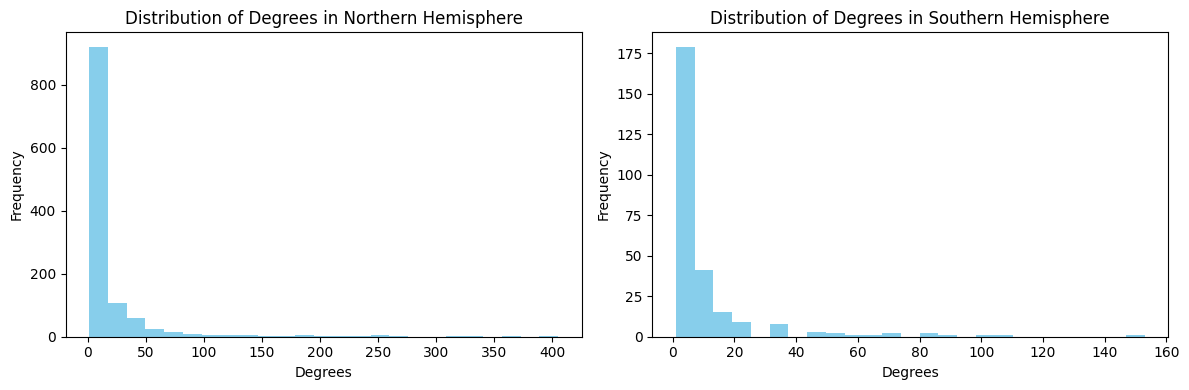

In [31]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(degN['Deg_Centrality'], 25, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees in Northern Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(degS['Deg_Centrality'], 25, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees in Southern Hemisphere')

plt.tight_layout()
plt.show()

The shapes of the two distributions are quite similar, but their ranges differ significantly. In the Northern Hemisphere, values range from 1 to 400, with the vast majority falling between 1 and 50. In contrast, the Southern Hemisphere's values range from 1 to only 160, with most values falling between 1 and 20.

**Calculate Eigenvector Centrality**

In [32]:
eig = nx.eigenvector_centrality(g)

In [33]:
eig_df = pd.DataFrame.from_dict(eig, orient='index').reset_index()
eig_df.columns = ['IATA', 'Eig_Centrality']
eig_df = pd.merge(eig_df, airports_raw, on='IATA', how='inner')
sorted_eig = eig_df.sort_values('Eig_Centrality', ascending = False)
sorted_eig.head()

,IATA,Eig_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
77,ATL,0.197612,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,N
43,ORD,0.187377,Chicago O'Hare International Airport,Chicago,United States,41.978600,-87.904800,N
126,DFW,0.181768,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,32.896801,-97.038002,N
570,IAH,0.167516,George Bush Intercontinental Houston Airport,Houston,United States,29.984400,-95.341400,N
561,EWR,0.166112,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,N


In [34]:
sorted_eig.tail()

,IATA,Eig_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
1128,PTH,1.493337e-22,Port Heiden Airport,Port Heiden,United States,56.959099,-158.632996,N
1127,KPV,1.493337e-22,Perryville Airport,Perryville,United States,55.905998,-159.162993,N
1126,IGG,1.493337e-22,Igiugig Airport,Igiugig,United States,59.324001,-155.901993,N
938,TTA,1.493337e-22,Tan Tan Airport,Tan Tan,Morocco,28.448200,-11.161300,N
123,TLJ,1.493337e-22,Tatalina LRRS Airport,Tatalina,United States,62.894402,-155.977005,N


Once again, the highest values are found exclusively at northern airports (all located in the USA), while the lowest values are also predominantly at northern airports.

**Eigenvector Centrality for Northern vs. Southern Hemisphere**

In [35]:
eig_df.iloc[:, [0,1,7]].groupby(['Hemisphere']).describe().reset_index()

Hemisphere Eig_Centrality                                              \
                      count      mean       std           min       25%   
0          N         1180.0  0.011517  0.026602  1.493337e-22  0.000137   
1          S          267.0  0.001665  0.005619  1.493337e-22  0.000062   

                                 
        50%       75%       max  
0  0.002140  0.008310  0.197612  
1  0.000147  0.000973  0.055050

**Distribution of Degree Centrality in Northern vs. Southern Hemisphere**

In [36]:
eigN = eig_df[eig_df.Hemisphere=='N']
eigS = eig_df[eig_df.Hemisphere=='S']

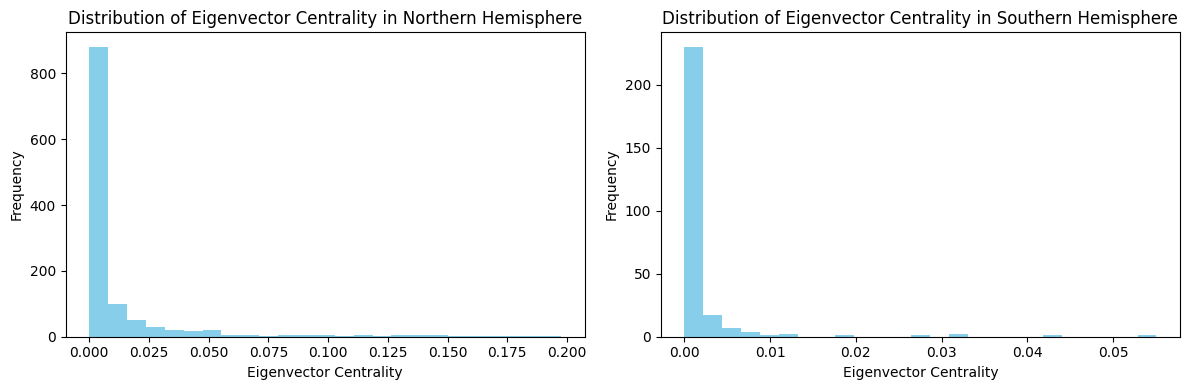

In [37]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(eigN['Eig_Centrality'], 25, color = "skyblue")
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvector Centrality in Northern Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(eigS['Eig_Centrality'], 25, color = "skyblue")
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvector Centrality in Southern Hemisphere')

plt.tight_layout()
plt.show()

Once again, the shapes of the two distributions are nearly identical, but their ranges differ significantly. In the Northern Hemisphere, values range from 0 to 0.05, with the vast majority falling within this range. In the Southern Hemisphere, values also range from 0 to 0.05, but most values fall between 0 and 0.01.



**T-Test:**

Let's perform a T-test to determine if the differences in the means of degree centrality and eigenvector centrality for Northern and Southern airports are statistically significant. Our null hypothesis is that the mean degree centrality is not statistically different between Northern and Southern airports, and similarly, that the mean eigenvector centrality is not statistically different between Northern and Southern airports.



In [38]:
degN1 = degN.iloc[:,[1]]
degS1 = degS.iloc[:,[1]]

t_deg,p_deg = stats.ttest_ind(degN1.values,degS1.values)

t_deg

array([3.02453543])

That T-value corresponds to a p value of:

In [40]:
p_deg

array([0.00253407])

Based on the p-value, I can reject the null hypothesis. We have statistical evidences to claim that northern airports on average have significantly higher degree centrality than southern airports.

Let's test Eigenvector Centrality next.

In [41]:
eigN = eig_df[eig_df.Hemisphere=='N']
eigS = eig_df[eig_df.Hemisphere=='S']

t_eig, p_eig = stats.ttest_ind(eigN.iloc[:,1],eigS.iloc[:,1])

p_eig

2.215358911381636e-09

**Visualize Air Routes Network**

Admittedly this is not the best way to visualize this netework. A graph that locates each node on a map would be better, and is a consideration for a future update.

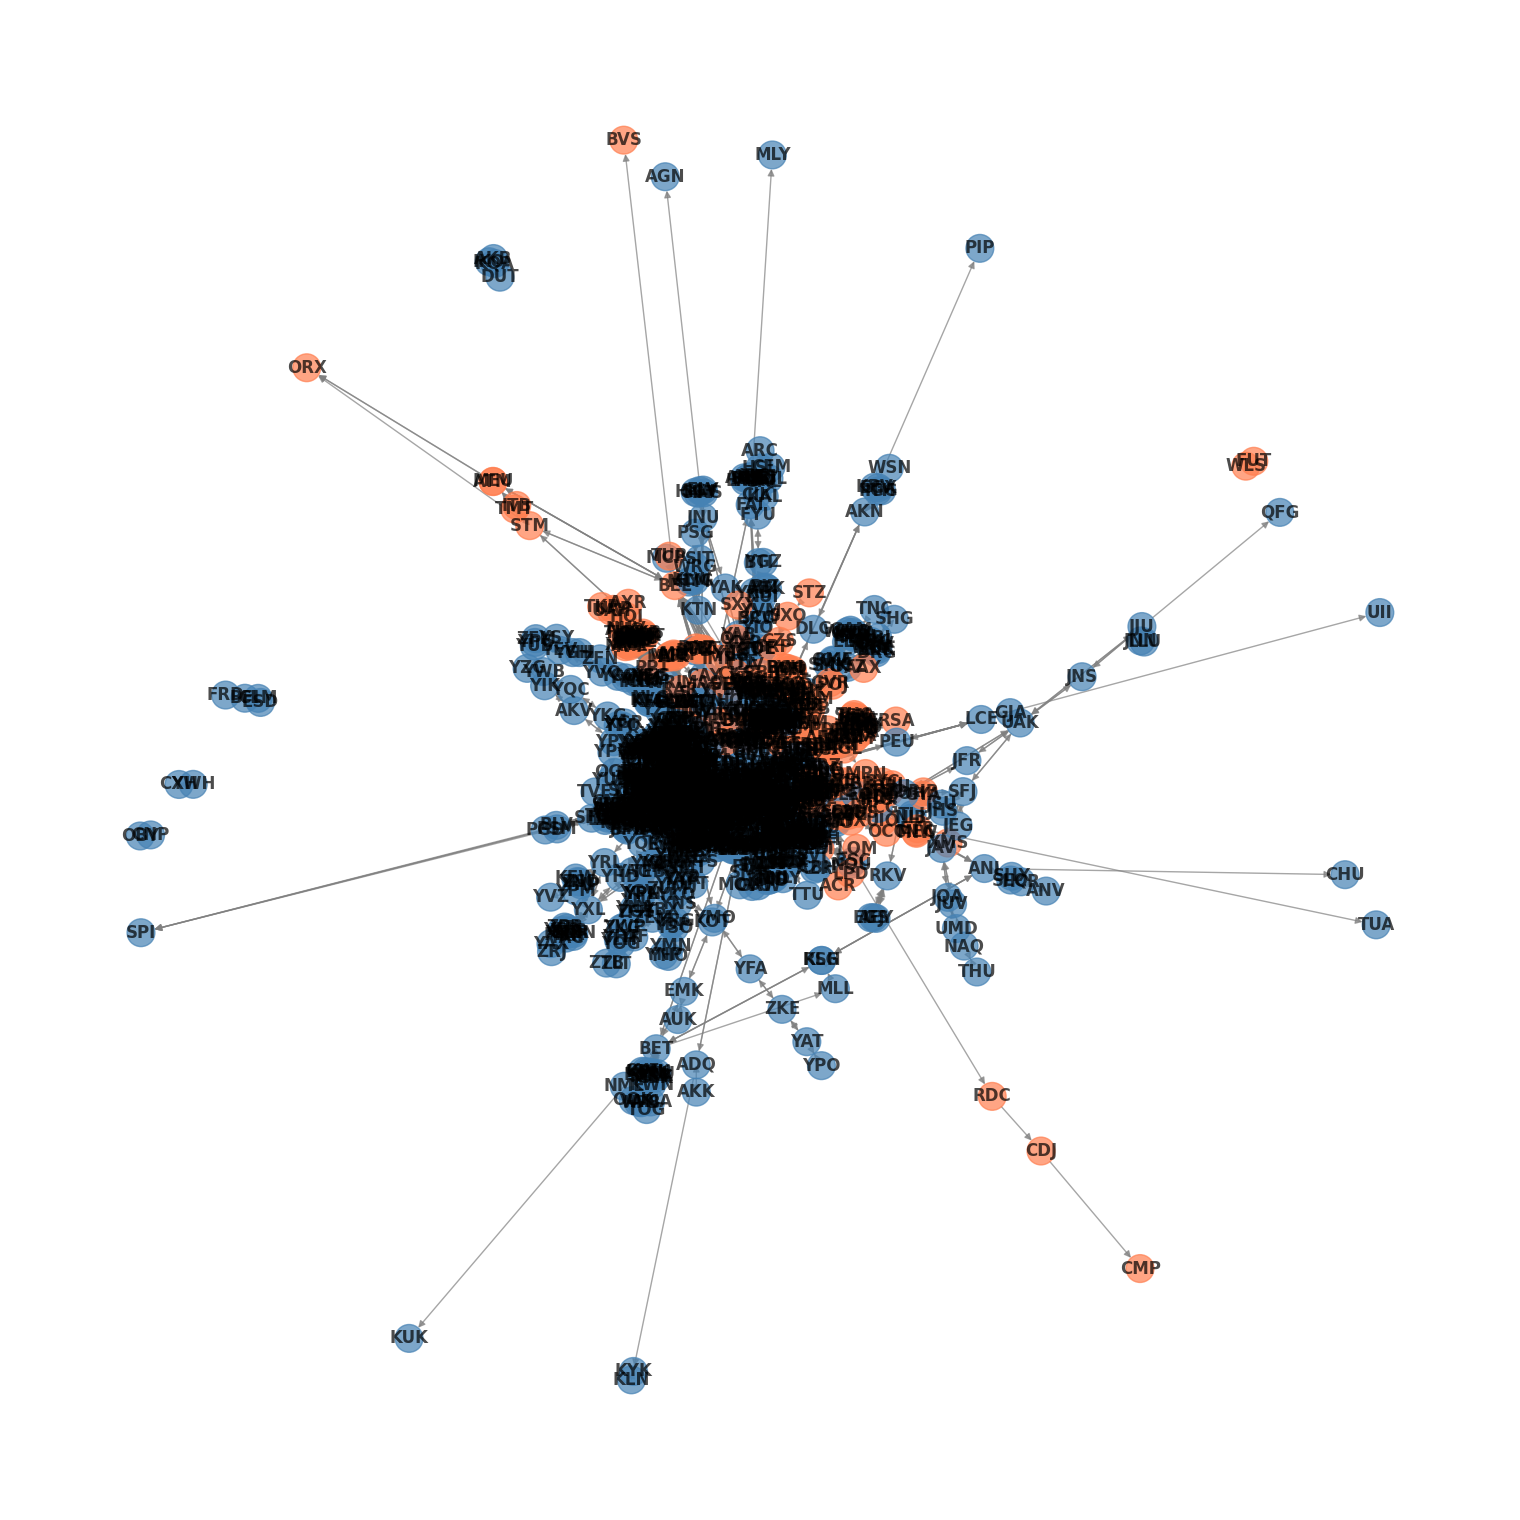

In [42]:
# set plot size
plt.rcParams["figure.figsize"] = (15,15)

# created empty list for node colors
colors = []

# for each node in the graph append the N or S color to the list
for node, data in g.nodes(data=True):
    if data['Hemisphere'] == 'N':
        colors.append('steelblue')
    else:
        colors.append('coral')

# Draw the Graph
nx.draw(g, with_labels=True, node_size=400, node_color=colors, font_weight='bold',
        edge_color="grey", alpha=0.7)

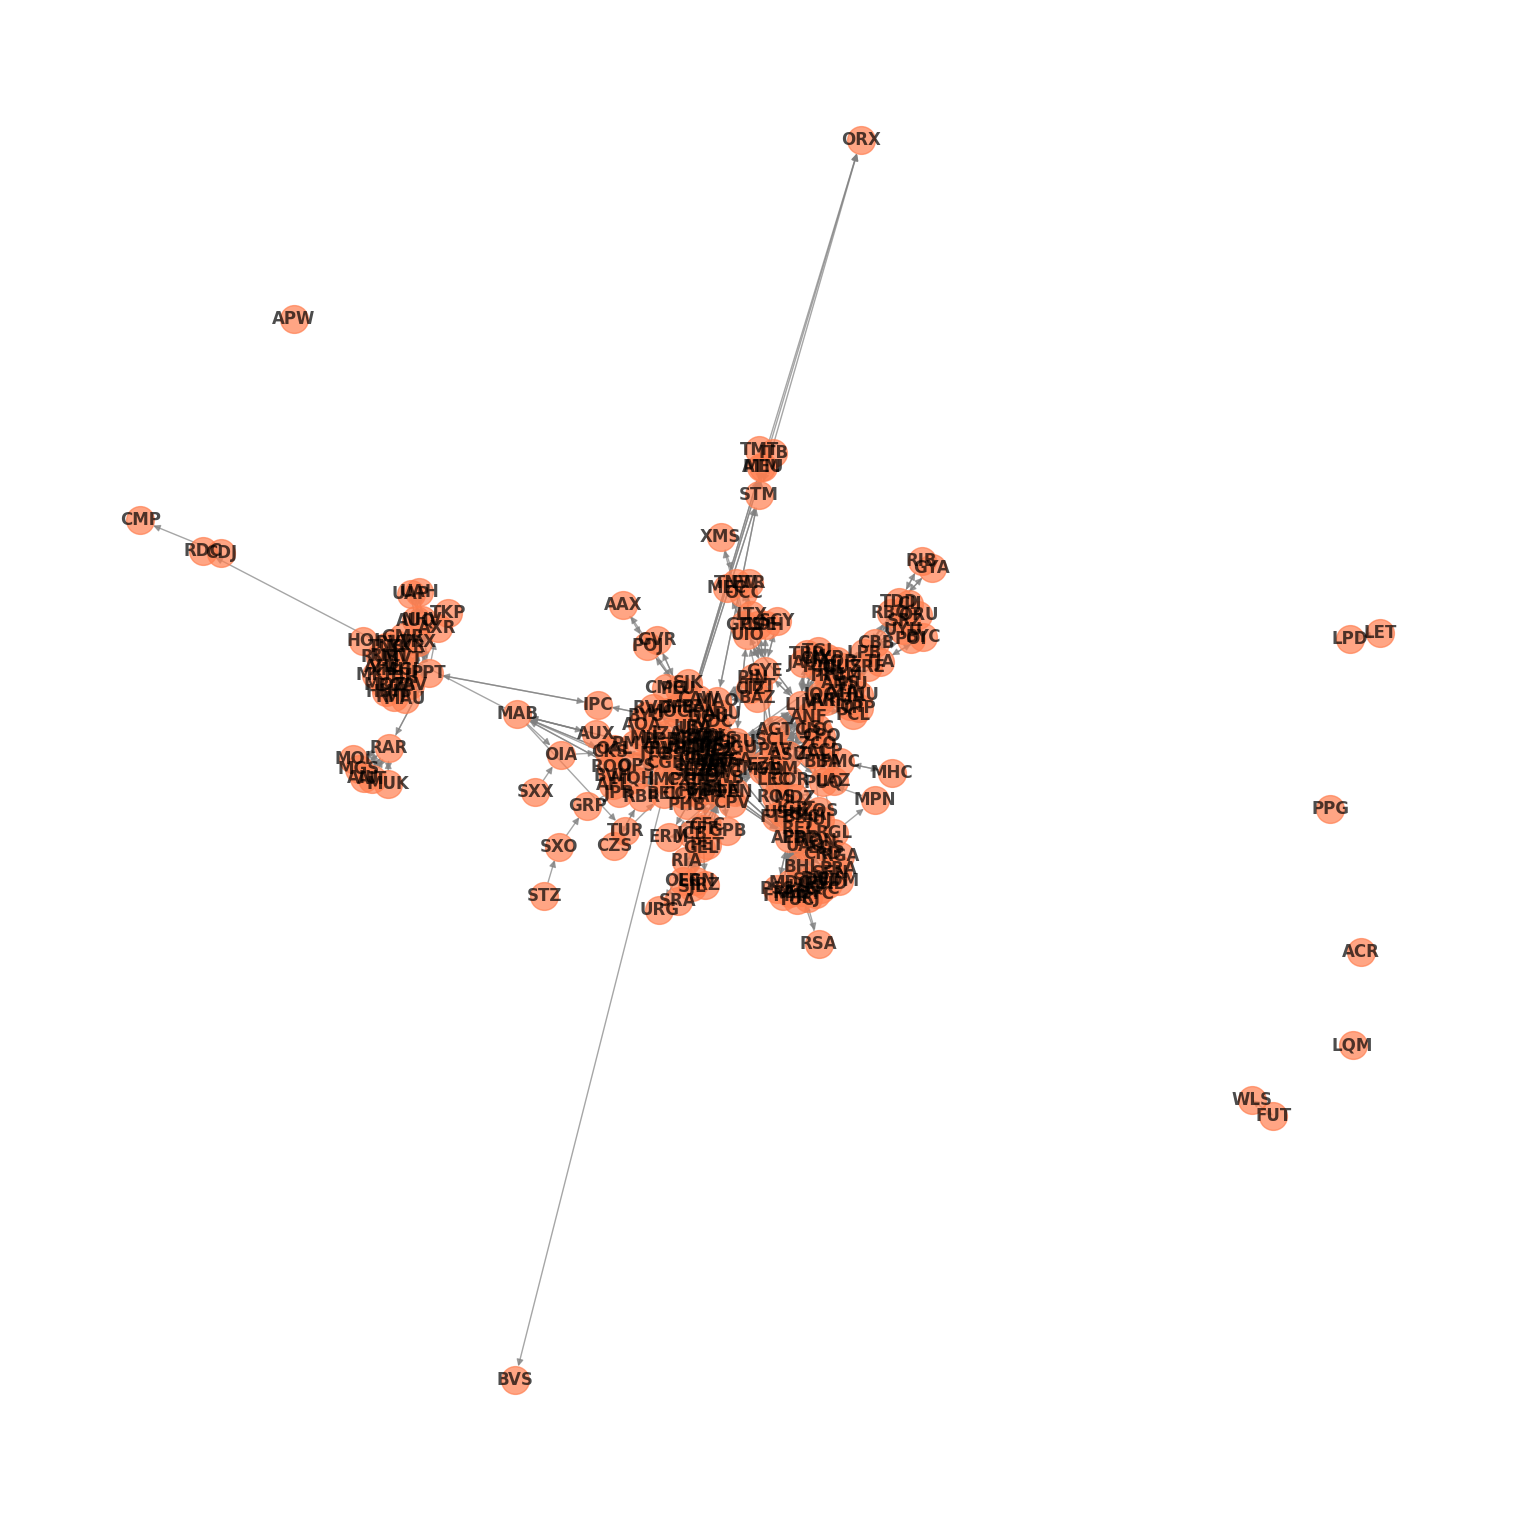

In [43]:
# set plot size
plt.rcParams["figure.figsize"] = (15,15)

I = g.subgraph(list(degS['IATA']))

# Draw the Graph
nx.draw(I, with_labels=True, node_size=400, node_color='coral', font_weight='bold',
        edge_color="grey", alpha=0.7)